In [26]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [13]:
# Load Cats vs Dogs dataset from TensorFlow Datasets
(train_ds, test_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

print("Dataset loaded successfully!")
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.SVMEDR_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset loaded successfully!
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
  

In [15]:
# 2️⃣ Preprocess function (resize + normalize + one-hot encode)
IMG_SIZE = (32, 32)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=2)   # cats vs dogs → 2 classes
    return image, label

In [17]:
# ✅ Step 3 – Preprocess Images (Resize + Normalize + One-Hot Encode)
# ============================================================
IMG_SIZE = (32, 32)                      # same as original notebook
NUM_CLASSES = info.features['label'].num_classes

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

train_ds = (
    train_ds
    .map(format_image)
    .shuffle(1000)
    .batch(5000)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(format_image)
    .batch(5000)
    .prefetch(tf.data.AUTOTUNE)
)


In [19]:
# Extract single batch so the rest of the notebook (x_train, y_train) works unchanged
x_train, y_train = next(iter(train_ds))
x_test, y_test   = next(iter(test_ds))

print("✅ Data ready:")
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:",  x_test.shape,  "y_test:",  y_test.shape)

✅ Data ready:
x_train: (5000, 32, 32, 3) y_train: (5000, 2)
x_test: (4652, 32, 32, 3) y_test: (4652, 2)


In [20]:
# ✅ Step 4 – Load Pre-Trained VGG16 Model (Base Feature Extractor)
# ============================================================
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in vgg.layers:
    layer.trainable = False

print("✅ VGG16 base model loaded and frozen")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ VGG16 base model loaded and frozen


In [21]:
# ✅ Step 5 – Build Custom Classifier on Top
# ============================================================
model = models.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 65,922 (257.51 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [22]:
# ✅ Step 6 – Compile the Model
# ============================================================
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [23]:
# ✅ Step 7 – Train the Model
# ============================================================
history = model.fit(
    x_train, y_train,
    epochs=5,
    validation_data=(x_test, y_test)
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 155s 978ms/step - accuracy: 0.5913 - loss: 0.6785 - val_accuracy: 0.7036 - val_loss: 0.5737
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 135s 865ms/step - accuracy: 0.6922 - loss: 0.5716 - val_accuracy: 0.7016 - val_loss: 0.5638
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 146s 890ms/step - accuracy: 0.7188 - loss: 0.5435 - val_accuracy: 0.7193 - val_loss: 0.5467
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 136s 855ms/step - accuracy: 0.7293 - loss: 0.5268 - val_accuracy: 0.7184 - val_loss: 0.5479
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 861ms/step - accuracy: 0.7431 - loss: 0.5149 - val_accuracy: 0.7221 - val_loss: 0.5413


In [24]:
# ✅ Step 8 – Evaluate Model on Test Data
# ============================================================
loss, acc = model.evaluate(x_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


146/146 ━━━━━━━━━━━━━━━━━━━━ 74s 505ms/step - accuracy: 0.7089 - loss: 0.5501
✅ Test Accuracy: 72.21%


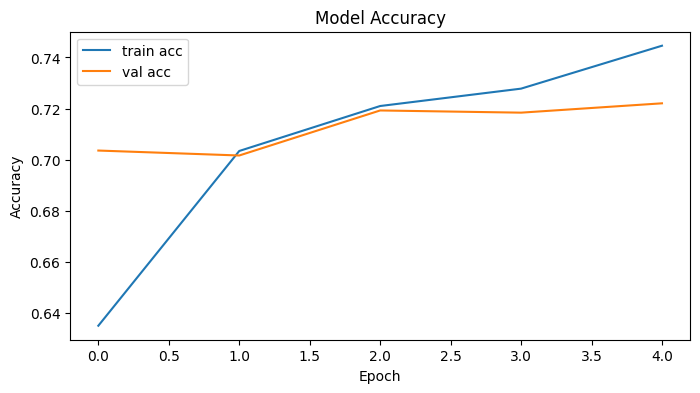

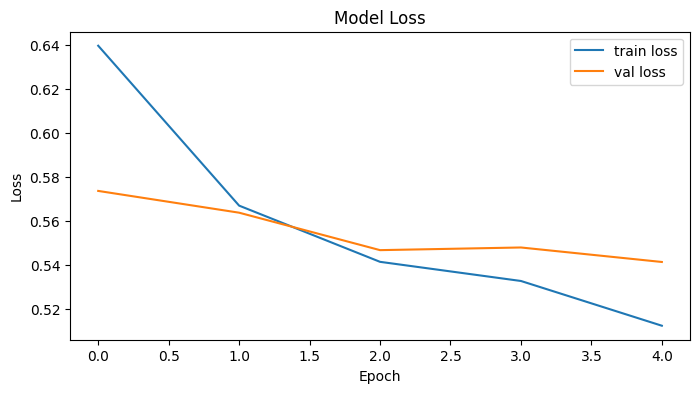

In [27]:
# ✅ Step 9 – Visualize Accuracy & Loss
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


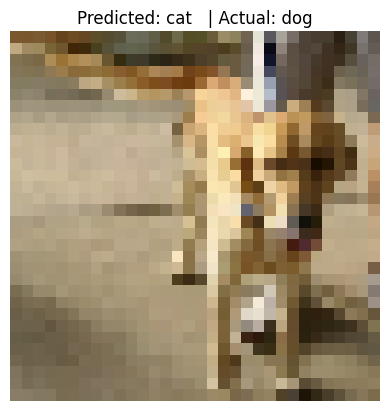

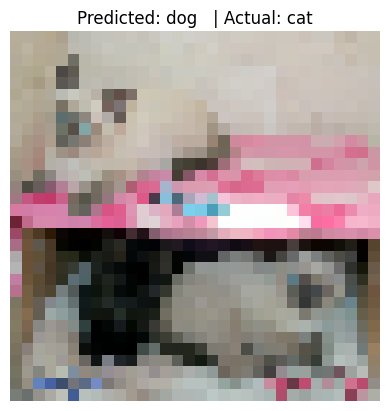

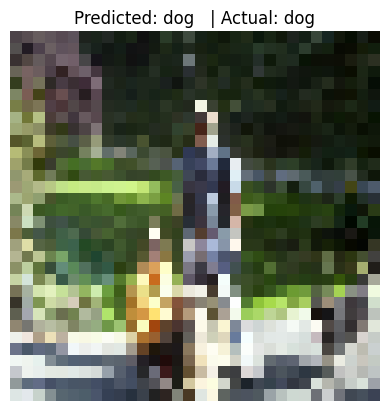

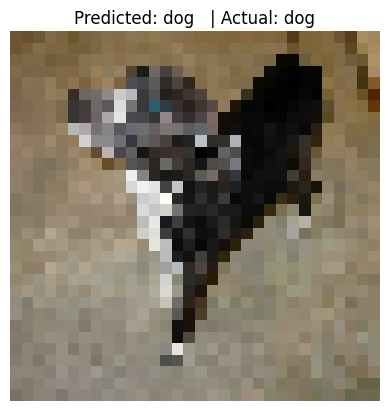

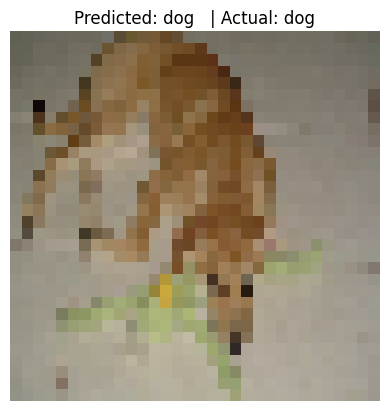

In [28]:
# ✅ Step 10 – Predict on Sample Images (Optional)
# ============================================================
predictions = model.predict(x_test[:5])
class_names = info.features['label'].names

for i in range(5):
    plt.imshow(x_test[i])
    plt.title(f"Predicted: {class_names[tf.argmax(predictions[i])]}  "
              f" | Actual: {class_names[tf.argmax(y_test[i])]}")
    plt.axis("off")
    plt.show()